## Import Relevant Libraries

In [17]:
from glob import glob
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import joblib

import librosa as lb
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [9]:
!pip install resampy
!pip install kaggle
!pip install tqdm  

  Using cached resampy-0.4.3-py3-none-any.whl.metadata (3.0 kB)
Using cached resampy-0.4.3-py3-none-any.whl (3.1 MB)
  Using cached kaggle-1.7.4.2-py3-none-any.whl.metadata (16 kB)
Using cached kaggle-1.7.4.2-py3-none-any.whl (173 kB)


## Load data

In [18]:
import os

paths = []
labels = []

# Define the root directory
audio_files_path = 'KAGGLE/AUDIO'

# Iterate through the subdirectories
for subdir in os.listdir(audio_files_path):
    subdir_path = os.path.join(audio_files_path, subdir)
    # Check if it's a directory
    if os.path.isdir(subdir_path):
        # Add all files in the subdirectory
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            paths.append(file_path)
            # Add label based on the subdirectory name
            labels.append(subdir)

print('Dataset is loaded')

Dataset is loaded


In [19]:
folders = os.listdir(audio_files_path)
print(folders)
print('paths:', len(paths))
print('labels:', len(labels))


['REAL', 'FAKE']
paths: 64
labels: 64


In [26]:
# Define file paths
real_audio = glob("KAGGLE/AUDIO/REAL/*")
fake_audio = glob("KAGGLE/AUDIO/FAKE/*")

real_audio.sort()
fake_audio.sort()

# Display file counts
print(f"Number of real audio samples: {len(real_audio)}")
print(f"Number of fake audio samples: {len(fake_audio)}")

Number of real audio samples: 8
Number of fake audio samples: 56


### Audio Demo

In [20]:
real_audio_demo = "DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio_demo = "DEMONSTRATION/linus-to-musk-DEMO.mp3"

#### Real Audio

In [21]:
import IPython
print("Real audio (Linus Sebastian):")
IPython.display.Audio(real_audio_demo)



Real audio (Linus Sebastian):


#### Fake Audio

In [22]:
print("DeepFake audio (Linus to Elon Musk):")
IPython.display.Audio(fake_audio_demo)

DeepFake audio (Linus to Elon Musk):


## EDA

### Helper Function

In [27]:
def get_spectrogram(y: np.ndarray) -> (np.ndarray, tuple):
    '''
    Compute the spectrogram of an audio signal.

    Parameters:
    y (np.ndarray): Audio time series.

    Returns:
    d (np.ndarray): Spectrogram of the audio signal, represented in decibels (dB).
    shape (tuple): Shape of the spectrogram (number of frequency bins, number of time frames).
    '''
    
    d = lb.stft(y)
    ad = lb.amplitude_to_db(np.abs(d), ref=np.max)
    
    return ad, ad.shape 

def plot_spectrogram(s: np.ndarray, sr: int = 22050, size: tuple=(10, 6), title: str = "Spectrogram of the Audio"):
    '''
    Plot a spectrogram.

    Parameters:
    s (np.ndarray): Spectrogram to plot. This should be a 2D array where the rows correspond to frequency bins and the columns correspond to time frames.
    sr (int, optional): Sampling rate of the audio. Default is 22050 Hz.
    size (tuple, optional): Size of the plot as (width, height). Default is (10, 6).
    title (str, optional): Title of the plot. Default is "Spectrogram of the Audio".
    '''
    
    plt.figure(figsize=size)
    lb.display.specshow(s, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def get_mel_spectrogram(y: np.ndarray, sr: int = 22050, n_mels: int = 128) -> (np.ndarray, tuple):
    '''
    Compute a Mel spectrogram from an audio signal.

    Parameters:
    y (np.ndarray): Audio time series.
    sr (int): Sampling rate of `y`. 
    n_mels (int): Number of Mel bands to generate. 

    Returns:
    mel_spectrogram (np.ndarray): 2D array representing the Mel spectrogram.
    shape (tuple): Shape of the Mel spectrogram (number of Mel bands, number of frames).
    ''' 
    ms = lb.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    m = lb.power_to_db(ms, ref=np.max) 
    
    return m, m.shape

def plot_mel_spectrogram(m: np.ndarray, sr: int = 22050, size: tuple = (10, 6), title: str = "Mel Spectrogram of Audio"):
    '''
    Plot a Mel spectrogram.

    Parameters:
    s (np.ndarray): Mel spectrogram to plot. 
    sr (int, optional): Sampling rate of the audio. Default is 22050 Hz.
    size (tuple, optional): Size of the plot as (width, height). Default is (10, 6).
    title (str, optional): Title of the plot. Default is "Mel Spectrogram of Audio".
    '''
    
    plt.figure(figsize=size)
    lb.display.specshow(m, x_axis='time', y_axis='mel', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

### visualize sample audio files

Loading sample audio files for analysis...


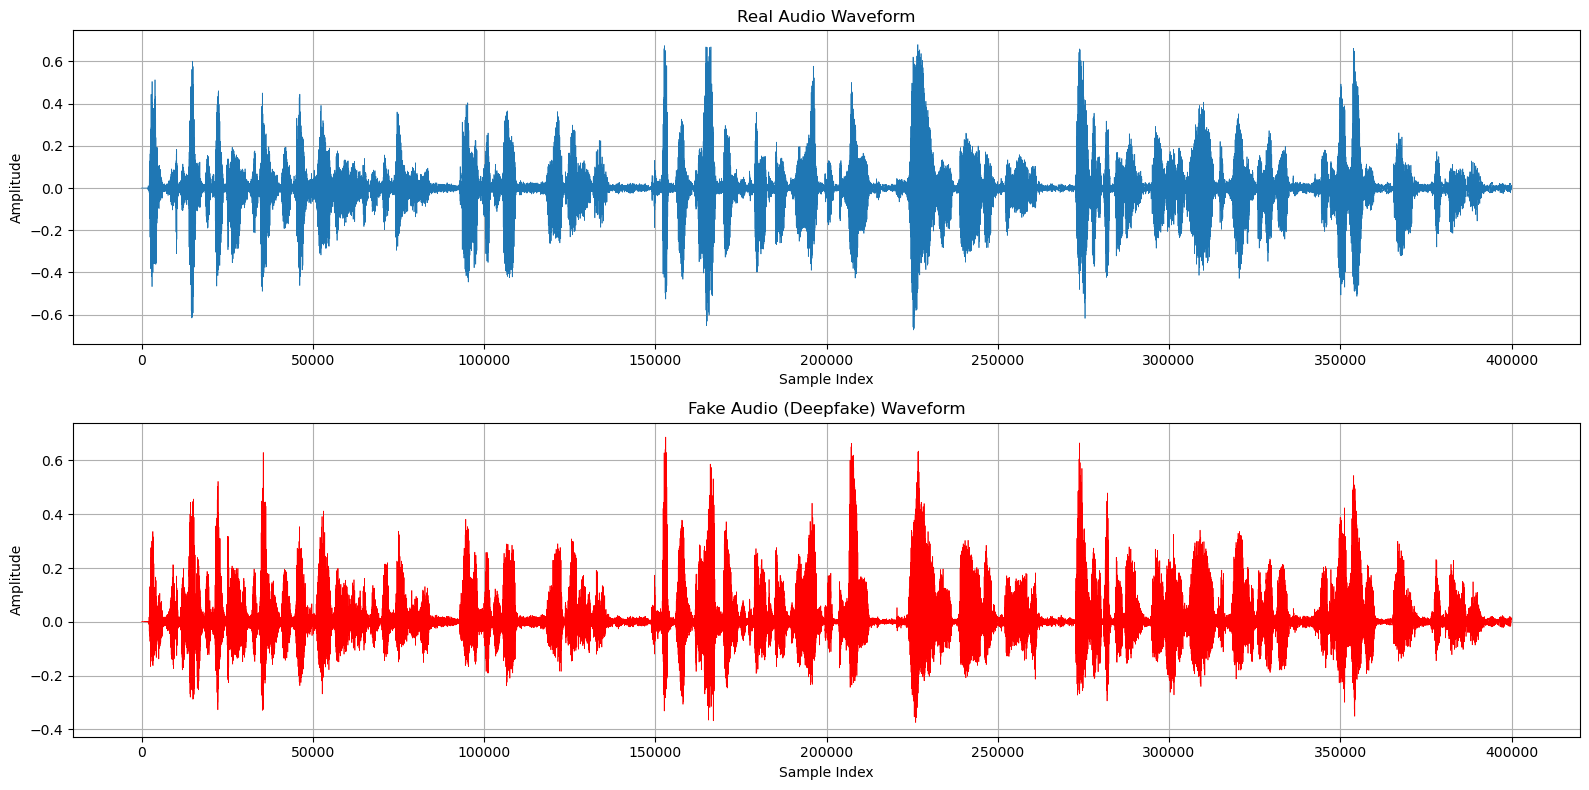

In [28]:
# Load and visualize sample audio files
print("Loading sample audio files for analysis...")
# Sample real audio
real_sample, sr_real = lb.load(real_audio[1])
real_sample_cut = real_sample[:400_000]  # Take first ~18 seconds (at 22050Hz)

# Sample fake audio
fake_sample, sr_fake = lb.load(fake_audio[15])
fake_sample_cut = fake_sample[:400_000]  # Take first ~18 seconds (at 22050Hz)

# Plot waveforms
plt.figure(figsize=(16, 8))

plt.subplot(2, 1, 1)
plt.plot(real_sample_cut, lw=0.5)
plt.title("Real Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(fake_sample_cut, lw=0.5, color='red')
plt.title("Fake Audio (Deepfake) Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

### Generate and plot spectrograms

Real audio spectrogram shape: (1025, 782)
Fake audio spectrogram shape: (1025, 782)


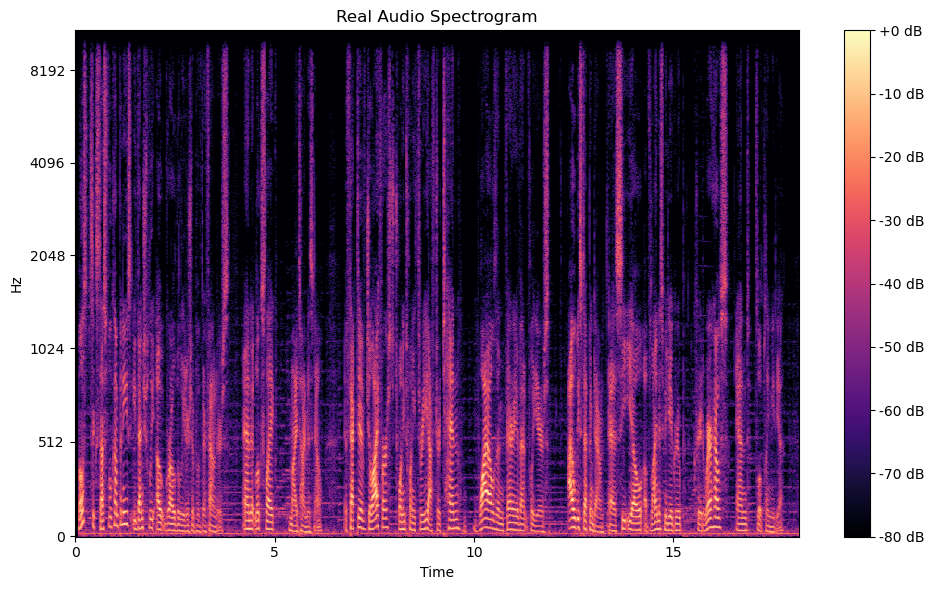

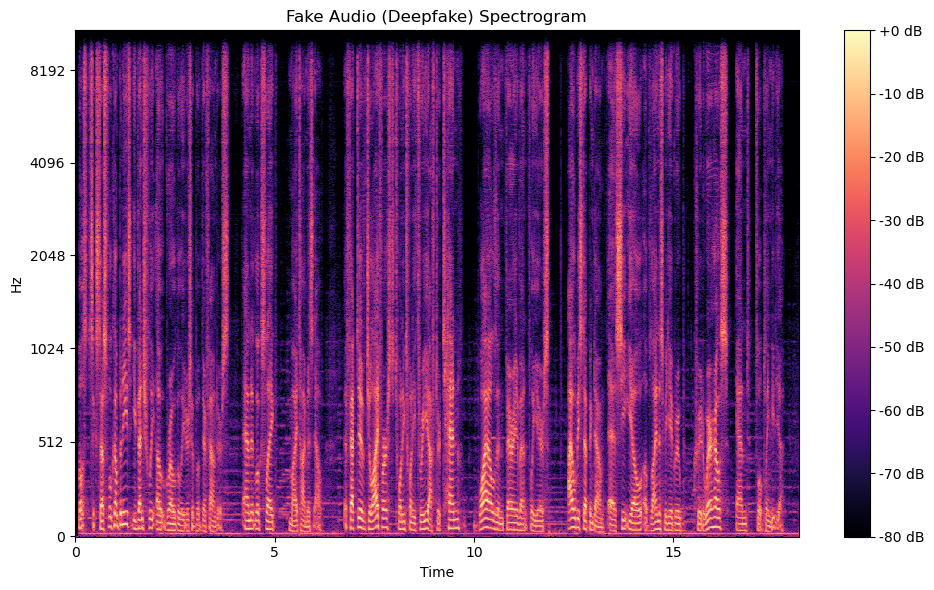

In [29]:
real_spec, real_spec_shape = get_spectrogram(real_sample_cut)
fake_spec, fake_spec_shape = get_spectrogram(fake_sample_cut)

print(f"Real audio spectrogram shape: {real_spec_shape}")
print(f"Fake audio spectrogram shape: {fake_spec_shape}")

plot_spectrogram(real_spec, title="Real Audio Spectrogram")
plot_spectrogram(fake_spec, title="Fake Audio (Deepfake) Spectrogram")

### Mel Spectrogram

Real audio mel spectrogram shape: (128, 782)
Fake audio mel spectrogram shape: (128, 782)


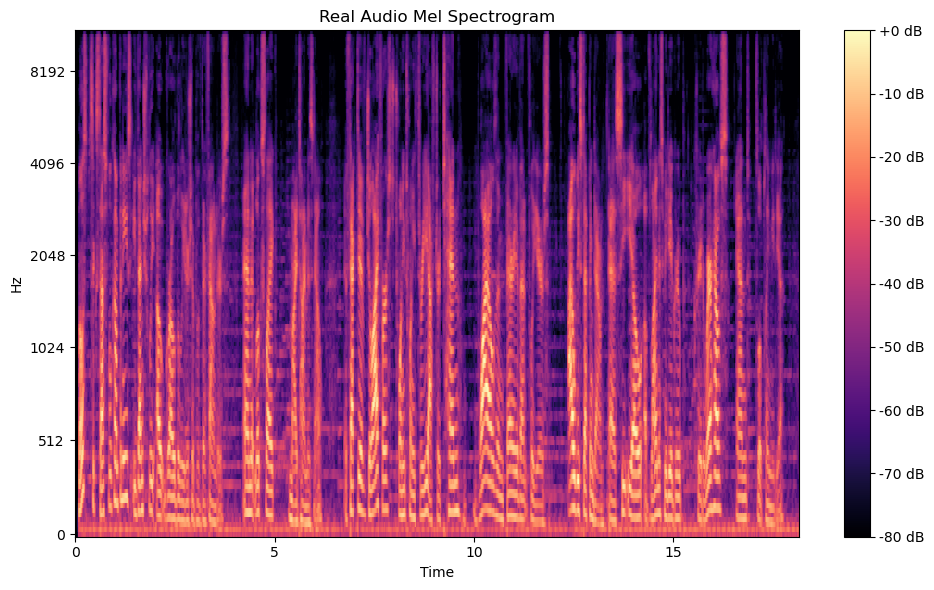

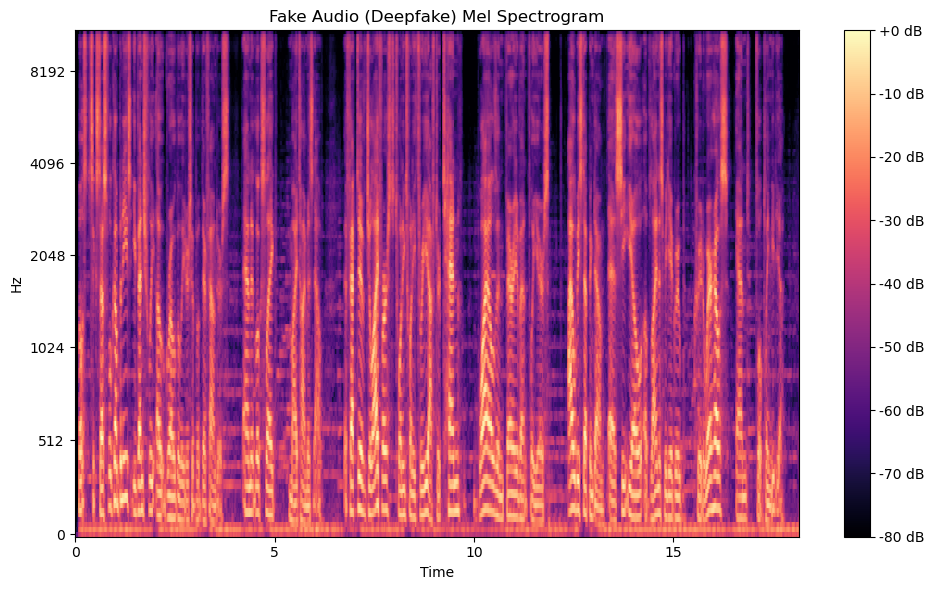

In [30]:
real_mel, real_mel_shape = get_mel_spectrogram(real_sample_cut, n_mels=128)
fake_mel, fake_mel_shape = get_mel_spectrogram(fake_sample_cut, n_mels=128)

print(f"Real audio mel spectrogram shape: {real_mel_shape}")
print(f"Fake audio mel spectrogram shape: {fake_mel_shape}")

plot_mel_spectrogram(real_mel, title="Real Audio Mel Spectrogram")
plot_mel_spectrogram(fake_mel, title="Fake Audio (Deepfake) Mel Spectrogram")

## Data Preprocessing

In [31]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

In [32]:
df['label'].value_counts()


label
FAKE    56
REAL     8
Name: count, dtype: int64

In [34]:
def create_mel_spectrogram_samples(y: np.ndarray, label: int, sr: int = 22050, samples: int = 10, 
                                  sample_time: float = 3, n_mels: int = 128) -> (np.ndarray, np.ndarray):
    '''
    Generate multiple mel spectrogram samples from a single audio signal.

    Parameters:
    y (np.ndarray): The audio signal.
    label (int): The label for the samples (0 for real, 1 for fake).
    sr (int): Sampling rate of the audio signal (default is 22050 Hz).
    samples (int): Number of samples to generate (default is 10).
    sample_time (float): Duration of each sample in seconds (default is 3).
    n_mels (int): Number of mel frequency bands (default is 128).

    Returns:
    samples (np.ndarray): Array of mel spectrogram samples.
    labels (np.ndarray): Array of labels containing the labels for the corresponding samples.
    '''
    
    start_time = time.time()
    
    sample_length = int(sr * sample_time)
    s, l = [], []
    
    if len(y) <= sample_length:
        # If audio is shorter than requested sample time, pad with zeros
        y_padded = np.pad(y, (0, sample_length - len(y)), 'constant')
        m, _ = get_mel_spectrogram(y_padded, sr=sr, n_mels=n_mels)
        m = np.abs(m)
        m /= 80  # Normalize
        s.append(m)
        l.append([label])
        
        # Duplicate to reach requested number of samples
        for _ in range(samples - 1):
            s.append(m)
            l.append([label])
    else:
        # Generate samples from different parts of the audio
        for _ in range(samples):
            start = random.randint(0, len(y) - sample_length)
            end = start + sample_length
            m, _ = get_mel_spectrogram(y[start:end], sr=sr, n_mels=n_mels)
            m = np.abs(m)
            m /= 80  # Normalize
            s.append(m)
            l.append([label])
    
    end_time = time.time()
    
    print(f"...Sample created with label = '{label}' | {samples} samples | Shape = {m.shape} | Time: {end_time-start_time:.3f}s...")
    return np.array(s), np.array(l)

def create_mfcc_samples(y: np.ndarray, label: int, sr: int = 22050, samples: int = 10, 
                       sample_time: float = 3, n_mfcc: int = 13) -> (np.ndarray, np.ndarray):
    """
    Create MFCC samples from an audio signal.

    Parameters:
    y (np.ndarray): The input audio signal.
    label (int): The label associated with the audio signal (0 for real, 1 for fake).
    sr (int, optional): The sampling rate of the audio signal. Defaults to 22050.
    samples (int, optional): The number of samples to generate. Defaults to 10.
    sample_time (float, optional): The duration (in seconds) of each sample. Defaults to 3.
    n_mfcc (int, optional): The number of MFCCs to extract. Defaults to 13.

    Returns:
    Tuple[np.ndarray, np.ndarray]: A tuple containing:
        - An array of shape (samples, n_mfcc * sample_length) with the MFCC features for each sample.
        - An array of shape (samples, 1) with the corresponding labels.
    """
    
    start_time = time.perf_counter()
    
    sample_length = int(sr * sample_time)
    s, l = [], []
    
    if len(y) <= sample_length:
        # If audio is shorter than requested sample time, pad with zeros
        y_padded = np.pad(y, (0, sample_length - len(y)), 'constant')
        mfcc = lb.feature.mfcc(y=y_padded, sr=sr, n_mfcc=n_mfcc)
        mfcc_flat = mfcc.flatten()
        
        # Standardize features
        mfcc_flat = (mfcc_flat - np.mean(mfcc_flat)) / (np.std(mfcc_flat) + 1e-8)
        
        s.append(mfcc_flat)
        l.append([label])
        
        # Duplicate to reach requested number of samples
        for _ in range(samples - 1):
            s.append(mfcc_flat)
            l.append([label])
    else:
        for _ in range(samples):
            start = random.randint(0, len(y) - sample_length)
            end = start + sample_length
            
            mfcc = lb.feature.mfcc(y=y[start:end], sr=sr, n_mfcc=n_mfcc)
            mfcc_flat = mfcc.flatten()
            
            # Standardize features
            mfcc_flat = (mfcc_flat - np.mean(mfcc_flat)) / (np.std(mfcc_flat) + 1e-8)
        
            s.append(mfcc_flat)
            l.append([label])
        
    end_time = time.perf_counter()
    
    print(f"...Sample created with label = '{label}' | {samples} samples | Shape = {mfcc_flat.shape} | Time: {end_time-start_time:.3f}s...")
    
    return np.array(s), np.array(l)

In [39]:
# Data preparation for CNN approach
print("\nPreparing data for CNN training...")

# Create balanced dataset with mel spectrograms
n_samples_per_class = 200
n_mels = 64
sample_duration = 1.5  # seconds

combined_samples_mel = []
combined_labels_mel = []

# Process real audio files (label 0 for real)
for audio_path in real_audio:
    audio_data, sr = lb.load(audio_path)
    samples, labels = create_mel_spectrogram_samples(
        y=audio_data, 
        label=0, 
        samples=n_samples_per_class, 
        sample_time=sample_duration, 
        n_mels=n_mels
    )
    combined_samples_mel.append(samples)
    combined_labels_mel.append(labels)

# Process fake audio files (label 1 for fake)
for audio_path in random.sample(fake_audio, k=len(real_audio)):  # Balance the classes
    audio_data, sr = lb.load(audio_path)
    samples, labels = create_mel_spectrogram_samples(
        y=audio_data, 
        label=1, 
        samples=n_samples_per_class, 
        sample_time=sample_duration, 
        n_mels=n_mels
    )
    combined_samples_mel.append(samples)
    combined_labels_mel.append(labels)

# Combine all samples
combined_samples_mel = np.concatenate(combined_samples_mel, axis=0)
combined_labels_mel = np.concatenate(combined_labels_mel, axis=0)

# Make sure labels are balanced
print(f"Total mel spectrogram samples: {combined_samples_mel.shape[0]}")
print(f"Class distribution: {np.bincount(combined_labels_mel.flatten())}")


Preparing data for CNN training...
...Sample created with label = '0' | 200 samples | Shape = (64, 65) | Time: 0.679s...
...Sample created with label = '0' | 200 samples | Shape = (64, 65) | Time: 0.550s...
...Sample created with label = '0' | 200 samples | Shape = (64, 65) | Time: 0.898s...
...Sample created with label = '0' | 200 samples | Shape = (64, 65) | Time: 0.869s...
...Sample created with label = '0' | 200 samples | Shape = (64, 65) | Time: 1.319s...
...Sample created with label = '0' | 200 samples | Shape = (64, 65) | Time: 1.067s...
...Sample created with label = '0' | 200 samples | Shape = (64, 65) | Time: 0.597s...
...Sample created with label = '0' | 200 samples | Shape = (64, 65) | Time: 0.632s...
...Sample created with label = '1' | 200 samples | Shape = (64, 65) | Time: 0.604s...
...Sample created with label = '1' | 200 samples | Shape = (64, 65) | Time: 0.858s...
...Sample created with label = '1' | 200 samples | Shape = (64, 65) | Time: 0.590s...
...Sample created 

In [40]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    combined_samples_mel, combined_labels_mel, test_size=0.3, stratify=combined_labels_mel, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# Reshape data for CNN (add channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print(f"CNN input shape: {X_train_cnn.shape[1:]}")

Training set: (2240, 64, 65), Validation set: (480, 64, 65), Test set: (480, 64, 65)
CNN input shape: (64, 65, 1)


In [41]:
# Define enhanced CNN model with more layers
def build_enhanced_cnn_model(input_shape=(64, 65, 1)):
    model = Sequential([
        # Input layer
        Input(shape=input_shape),
        
        # First convolutional block
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        # Second convolutional block
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Third convolutional block
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        # Flatten and dense layers
        Flatten(),
        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Build and compile the enhanced CNN model
enhanced_cnn_model = build_enhanced_cnn_model(input_shape=X_train_cnn.shape[1:])
enhanced_cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 65, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 65, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 65, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 65, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 16, 16, 128)    │             

 Total params: 2,420,193 (9.23 MB)

 Trainable params: 2,418,529 (9.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [42]:
# Define callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_deepfake_detector.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
enhanced_cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.F1Score(threshold=0.5)]
)

# Train the model with callbacks
print("Training enhanced CNN model...")
history = enhanced_cnn_model.fit(
    X_train_cnn,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_cnn, y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Training enhanced CNN model...
Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6308 - f1_score: 0.6220 - loss: 0.6823
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_deepfake_detector.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.6318 - f1_score: 0.6228 - loss: 0.6809 - val_accuracy: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: 1.0031 - learning_rate: 0.0010
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8202 - f1_score: 0.8096 - loss: 0.4165
Epoch 2: val_accuracy did not improve from 0.50000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.8202 - f1_score: 0.8096 - loss: 0.4163 - val_accuracy: 0.5000 - val_f1_score: 0.0000e+00 - val_loss: 0.8288 - learning_rate: 0.0010
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8510 - f1_score: 0.8415 - loss: 0.3183
Epoch 3: val_accuracy did not improve from 0.50000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.8511 - f1_score: 0.841

### Training Results

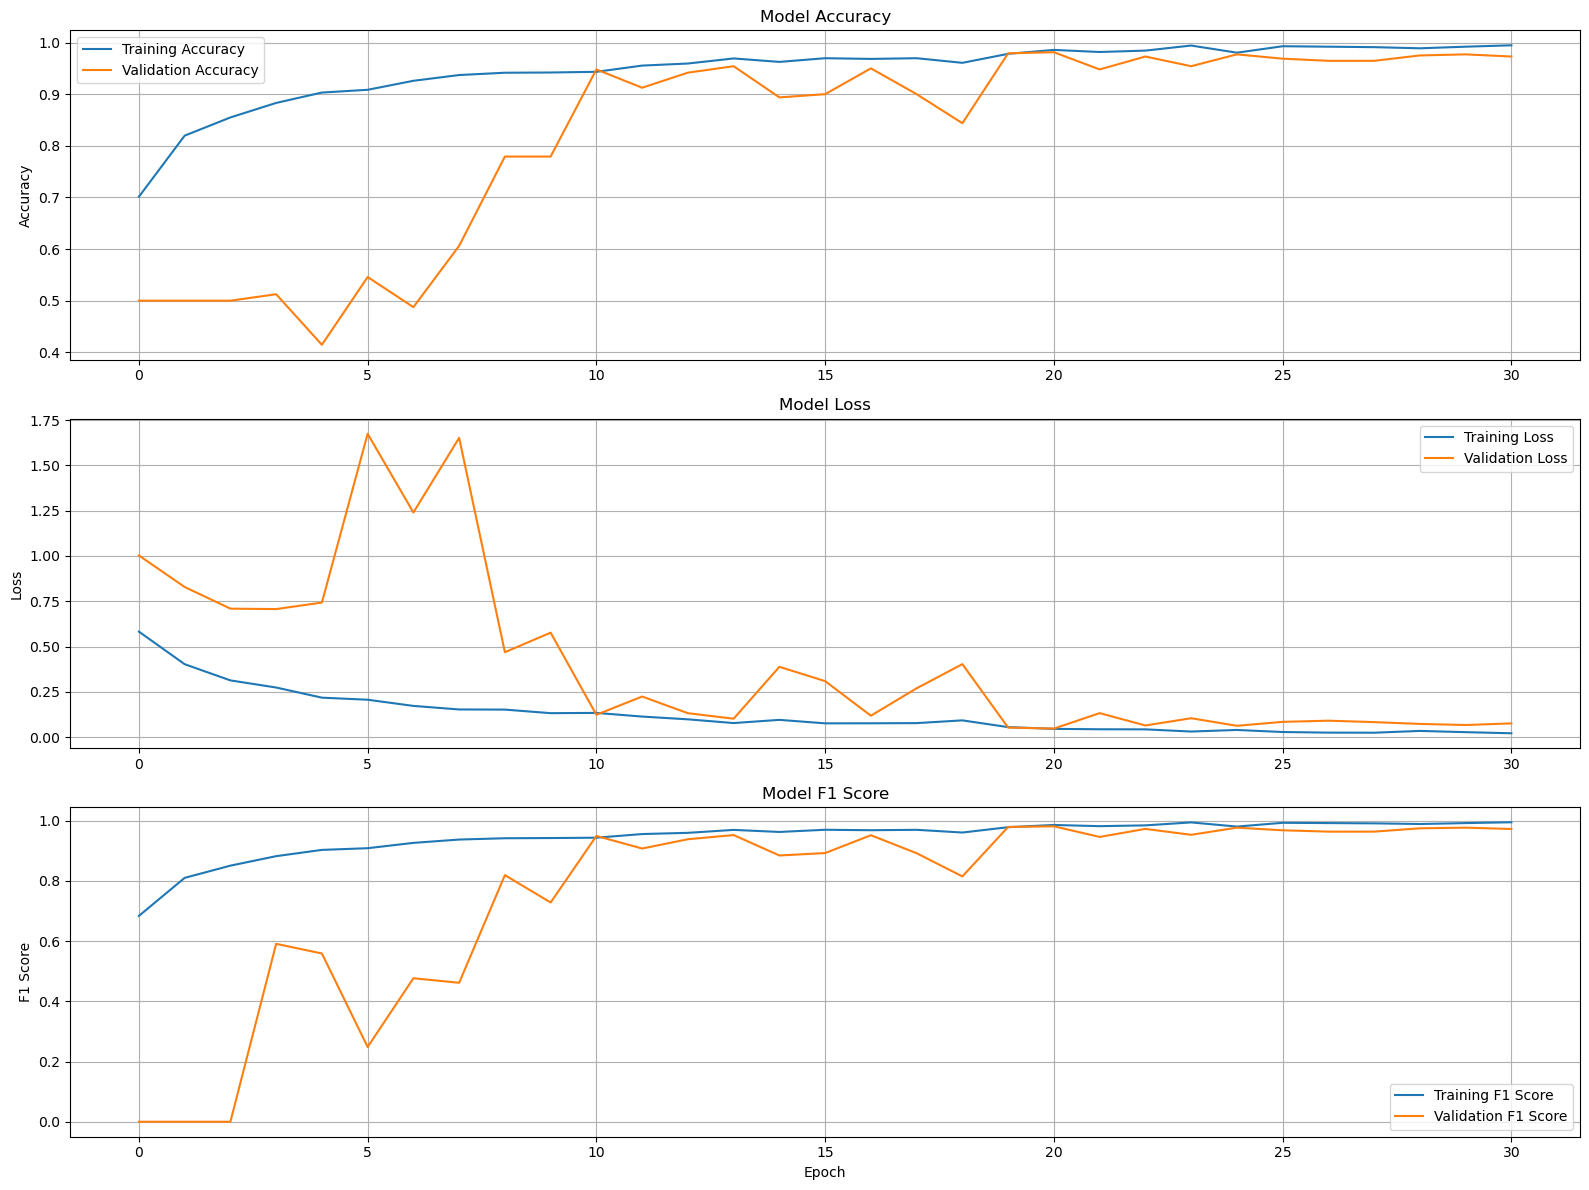

In [43]:
# Plot training history
plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.title('Model F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Model evaluation


Evaluating model on test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9753 - f1_score: 0.9753 - loss: 0.0431
Test Loss: 0.0457
Test Accuracy: 0.9771
Test F1 Score: 0.9774
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


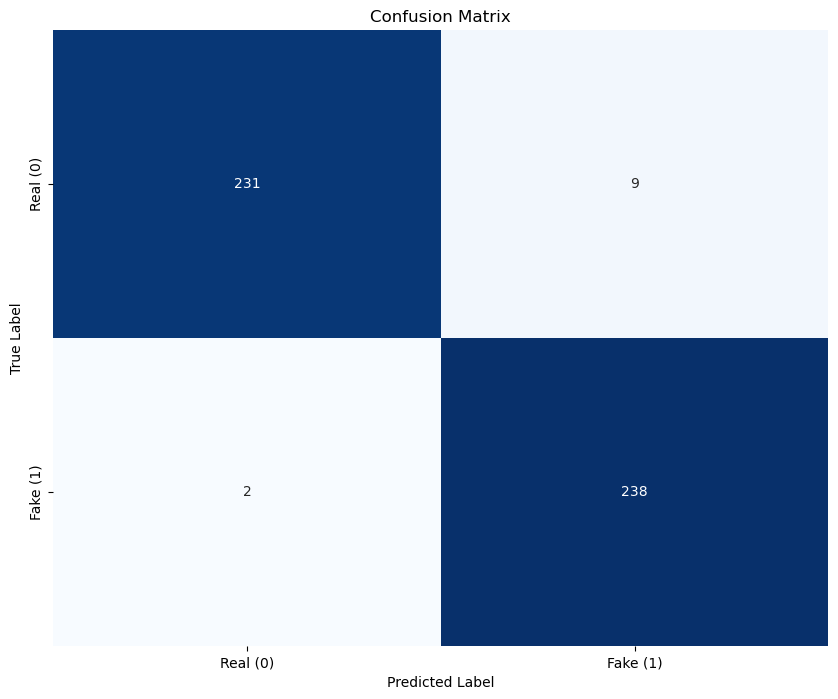

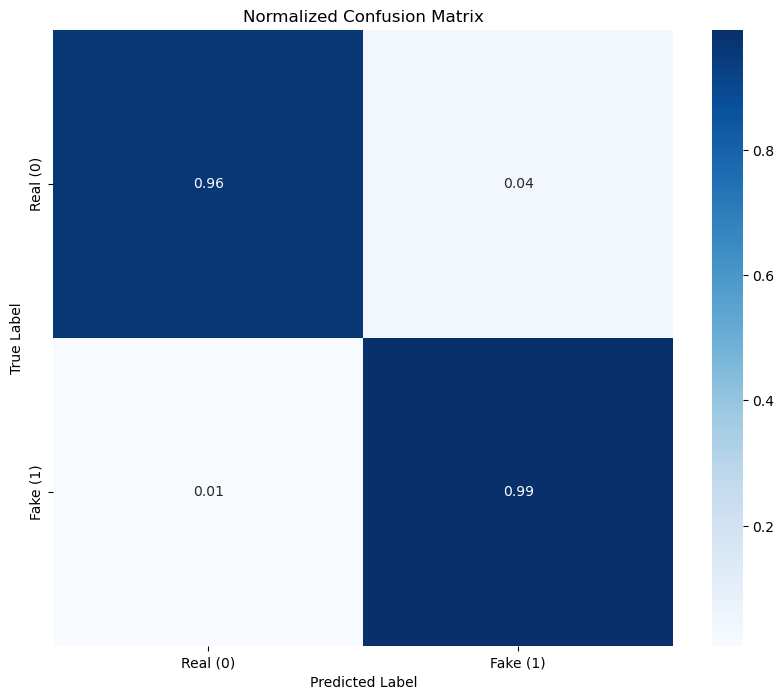

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.96      0.98       240
        Fake       0.96      0.99      0.98       240

    accuracy                           0.98       480
   macro avg       0.98      0.98      0.98       480
weighted avg       0.98      0.98      0.98       480



In [44]:
# Evaluate model on test set
print("\nEvaluating model on test set...")
test_loss, test_accuracy, test_f1 = enhanced_cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Predict on test set
y_pred_prob = enhanced_cnn_model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = y_test.astype(int)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Real (0)', 'Fake (1)'])
plt.yticks([0.5, 1.5], ['Real (0)', 'Fake (1)'])
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Real (0)', 'Fake (1)'])
plt.yticks([0.5, 1.5], ['Real (0)', 'Fake (1)'])
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Real', 'Fake'])
print("Classification Report:")
print(report)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

Analysis of Predictions:
Correctly classified real samples: 5
Correctly classified fake samples: 5
Incorrectly classified real samples (false positives): 5
Incorrectly classified fake samples (false negatives): 2


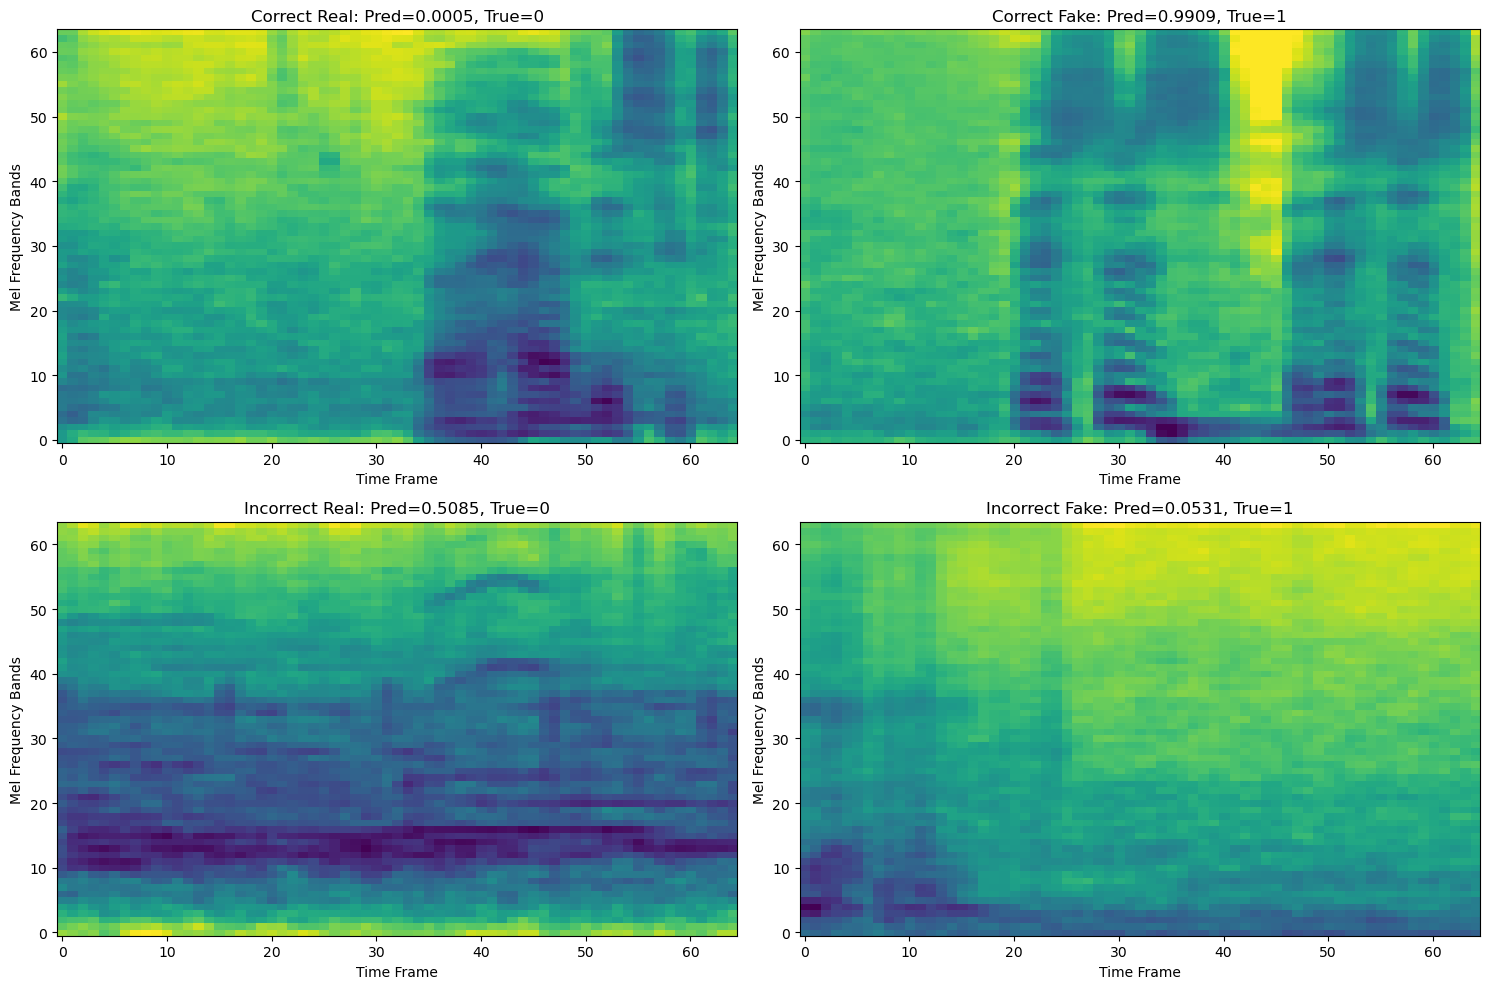

In [45]:
# Analyze model performance on specific samples
def analyze_predictions(model, X_test, y_test, n_samples=5):
    """
    Analyze model predictions on specific test samples.
    
    Parameters:
    model: Trained model
    X_test: Test data
    y_test: Test labels
    n_samples: Number of samples to analyze per class
    """
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Find indices of correctly and incorrectly classified samples
    correct_indices = np.where(y_pred.flatten() == y_test.flatten())[0]
    incorrect_indices = np.where(y_pred.flatten() != y_test.flatten())[0]
    
    # Analyze correct predictions (both real and fake)
    real_correct = [i for i in correct_indices if y_test[i] == 0][:n_samples]
    fake_correct = [i for i in correct_indices if y_test[i] == 1][:n_samples]
    
    # Analyze incorrect predictions (both real and fake)
    real_incorrect = [i for i in incorrect_indices if y_test[i] == 0][:n_samples]
    fake_incorrect = [i for i in incorrect_indices if y_test[i] == 1][:n_samples]
    
    # Display results
    print("\nAnalysis of Predictions:")
    print(f"Correctly classified real samples: {len(real_correct)}")
    print(f"Correctly classified fake samples: {len(fake_correct)}")
    print(f"Incorrectly classified real samples (false positives): {len(real_incorrect)}")
    print(f"Incorrectly classified fake samples (false negatives): {len(fake_incorrect)}")
    
    # Plot some examples
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot a correctly classified real example
    if real_correct:
        idx = real_correct[0]
        axes[0, 0].imshow(X_test[idx, :, :, 0], aspect='auto', origin='lower')
        axes[0, 0].set_title(f"Correct Real: Pred={y_pred_prob[idx][0]:.4f}, True=0")
        axes[0, 0].set_ylabel("Mel Frequency Bands")
        axes[0, 0].set_xlabel("Time Frame")
    
    # Plot a correctly classified fake example
    if fake_correct:
        idx = fake_correct[0]
        axes[0, 1].imshow(X_test[idx, :, :, 0], aspect='auto', origin='lower')
        axes[0, 1].set_title(f"Correct Fake: Pred={y_pred_prob[idx][0]:.4f}, True=1")
        axes[0, 1].set_ylabel("Mel Frequency Bands")
        axes[0, 1].set_xlabel("Time Frame")
    
    # Plot an incorrectly classified real example (false positive)
    if real_incorrect:
        idx = real_incorrect[0]
        axes[1, 0].imshow(X_test[idx, :, :, 0], aspect='auto', origin='lower')
        axes[1, 0].set_title(f"Incorrect Real: Pred={y_pred_prob[idx][0]:.4f}, True=0")
        axes[1, 0].set_ylabel("Mel Frequency Bands")
        axes[1, 0].set_xlabel("Time Frame")
    
    # Plot an incorrectly classified fake example (false negative)
    if fake_incorrect:
        idx = fake_incorrect[0]
        axes[1, 1].imshow(X_test[idx, :, :, 0], aspect='auto', origin='lower')
        axes[1, 1].set_title(f"Incorrect Fake: Pred={y_pred_prob[idx][0]:.4f}, True=1")
        axes[1, 1].set_ylabel("Mel Frequency Bands")
        axes[1, 1].set_xlabel("Time Frame")
    
    plt.tight_layout()
    plt.show()

# Analyze specific predictions
analyze_predictions(enhanced_cnn_model, X_test_cnn, y_test)

## Alternative SVM model

In [46]:
# Alternative models: MFCC-based approach with ML classifiers
print("\nPreparing MFCC features for traditional ML models...")

# Create dataset with MFCC features
combined_samples_mfcc = []
combined_labels_mfcc = []

# Limit the number of files for demonstration purposes
n_real_files = min(5, len(real_audio))
n_fake_files = min(5, len(fake_audio))

# Process real audio files (label 0 for real)
for audio_path in real_audio[:n_real_files]:
    audio_data, sr = lb.load(audio_path)
    samples, labels = create_mfcc_samples(
        y=audio_data, 
        label=0, 
        samples=100, 
        sample_time=3, 
        n_mfcc=20
    )
    combined_samples_mfcc.append(samples)
    combined_labels_mfcc.append(labels)

# Process fake audio files (label 1 for fake)
for audio_path in fake_audio[:n_fake_files]:
    audio_data, sr = lb.load(audio_path)
    samples, labels = create_mfcc_samples(
        y=audio_data, 
        label=1, 
        samples=100, 
        sample_time=3, 
        n_mfcc=20
    )
    combined_samples_mfcc.append(samples)
    combined_labels_mfcc.append(labels)

# Combine all samples
combined_samples_mfcc = np.concatenate(combined_samples_mfcc, axis=0)
combined_labels_mfcc = np.concatenate(combined_labels_mfcc, axis=0).flatten()

# Split data for ML models
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    combined_samples_mfcc, combined_labels_mfcc, test_size=0.3, stratify=combined_labels_mfcc, random_state=42
)

print(f"MFCC features shape: {combined_samples_mfcc.shape}")
print(f"ML training set: {X_train_ml.shape}, Test set: {X_test_ml.shape}")


Preparing MFCC features for traditional ML models...
...Sample created with label = '0' | 100 samples | Shape = (2600,) | Time: 0.786s...
...Sample created with label = '0' | 100 samples | Shape = (2600,) | Time: 0.635s...
...Sample created with label = '0' | 100 samples | Shape = (2600,) | Time: 0.793s...
...Sample created with label = '0' | 100 samples | Shape = (2600,) | Time: 0.488s...
...Sample created with label = '0' | 100 samples | Shape = (2600,) | Time: 0.728s...
...Sample created with label = '1' | 100 samples | Shape = (2600,) | Time: 0.559s...
...Sample created with label = '1' | 100 samples | Shape = (2600,) | Time: 0.715s...
...Sample created with label = '1' | 100 samples | Shape = (2600,) | Time: 0.635s...
...Sample created with label = '1' | 100 samples | Shape = (2600,) | Time: 0.484s...
...Sample created with label = '1' | 100 samples | Shape = (2600,) | Time: 0.520s...
MFCC features shape: (1000, 2600)
ML training set: (700, 2600), Test set: (300, 2600)



Training SVM model...
SVM Accuracy: 0.8533
SVM F1 Score: 0.8523


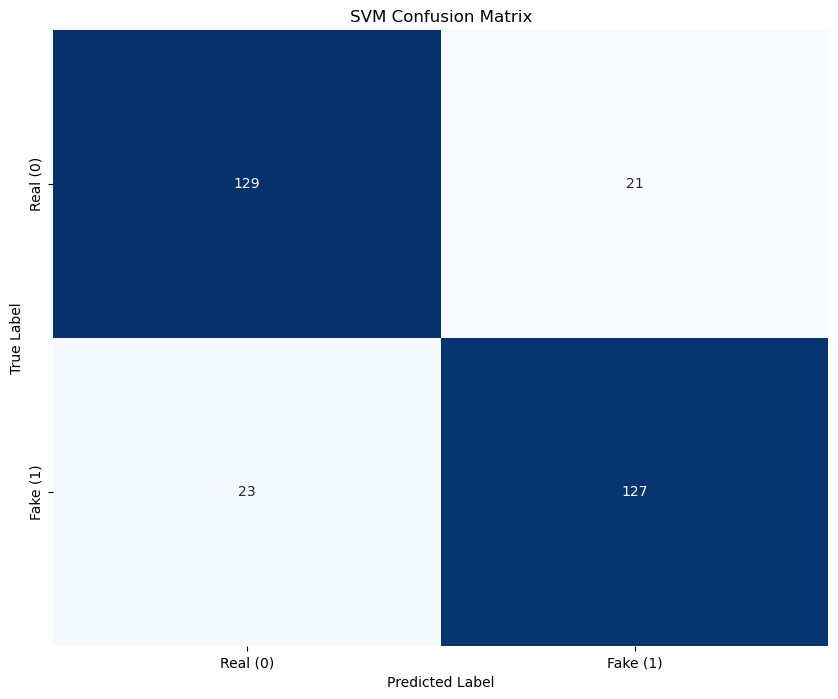

In [47]:
# Train SVM model
print("\nTraining SVM model...")
svm_model = svm.SVC(kernel='rbf', C=3, probability=True)
svm_model.fit(X_train_ml, y_train_ml)

# Evaluate SVM model
y_pred_svm = svm_model.predict(X_test_ml)
svm_accuracy = accuracy_score(y_test_ml, y_pred_svm)
svm_f1 = f1_score(y_test_ml, y_pred_svm)

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"SVM F1 Score: {svm_f1:.4f}")

# Create confusion matrix for SVM
cm_svm = confusion_matrix(y_test_ml, y_pred_svm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Real (0)', 'Fake (1)'])
plt.yticks([0.5, 1.5], ['Real (0)', 'Fake (1)'])
plt.show()

### Model comparision

/var/folders/52/3rwg_9dd2pbgcz76xgtfdlyw0000gn/T/ipykernel_40798/428101588.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracy_scores, palette='viridis')
/var/folders/52/3rwg_9dd2pbgcz76xgtfdlyw0000gn/T/ipykernel_40798/428101588.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_scores, palette='magma')


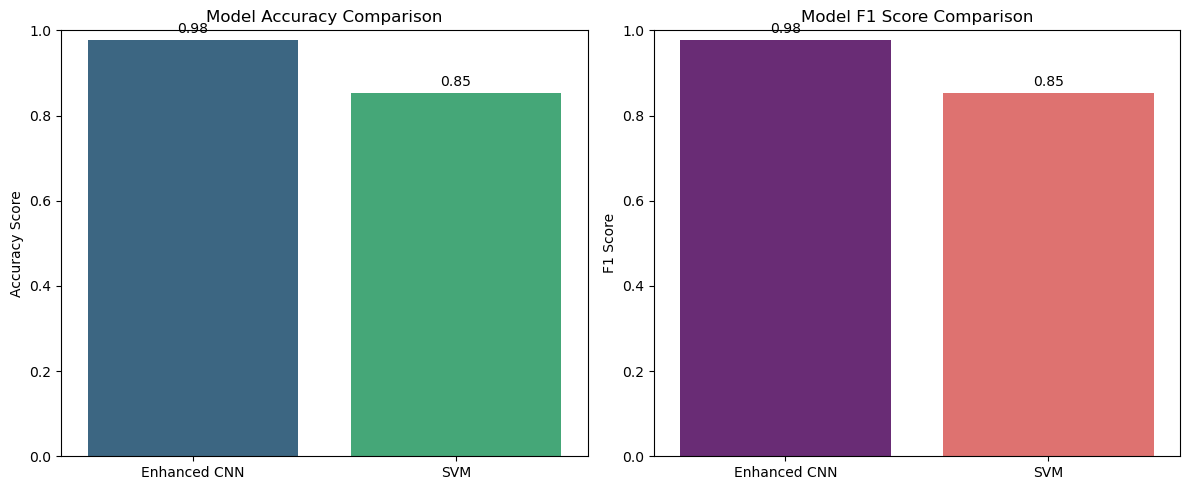

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Model names
models = ['Enhanced CNN', 'SVM']

# Scores (ensure these are defined in your previous code)
accuracy_scores = [test_accuracy, svm_accuracy]
f1_scores = [test_f1, svm_f1]

# Plot settings
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
sns.barplot(x=models, y=accuracy_scores, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', va='bottom')

# F1 Score plot
plt.subplot(1, 2, 2)
sns.barplot(x=models, y=f1_scores, palette='magma')
plt.title('Model F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
for i, f1 in enumerate(f1_scores):
    plt.text(i, f1 + 0.01, f"{f1:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()